In [6]:
import numpy as np
from matplotlib import pyplot as plt
# from skimage.color import rgb2gray
# from skimage.data import stereo_motorcycle, vortex
# from skimage.transform import warp
# from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage import io
import scipy.ndimage as ndimage
from glob import glob
import SimpleITK as sitk
from skimage.segmentation import active_contour
from skimage.filters import gaussian
sitk.ApproximateSignedDistanceMap(

In [274]:
im_list = sorted(glob('./*.tif'))

def read_tiff_image(inputImageFileName):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("TIFFImageIO")
    reader.SetFileName(inputImageFileName)
    image = reader.Execute()
    return image

def write_image(image, outputImageFileName):
    writer = sitk.ImageFileWriter()
    writer.SetFileName(outputImageFileName)
    writer.Execute(image)
    print(f"Image written to: {outputImageFileName}")

def sitk_reg_2d(fixed_image,moving_image, scaling_factor=64, iterations=1000):
    
    #log scaling approach for shrink and smooths, from @piloubazin nighres
    #tested, seems to perform worse???
    import math
    n_scales = math.ceil(math.log(scaling_factor)/math.log(2.0))
    
    smooth=[]
    shrink=[]
    for n in range(n_scales):
        # smooth.append(scaling_factor/math.pow(2.0,n+1)-1)
        shrink.append(math.ceil(scaling_factor/math.pow(2.0,n+1)))
    
    smooth = list(np.floor(np.array(shrink)/2))

    shrink = [6,4,2,1]
    smooth = [3,2,1,0]
    print(f"shrink factors: {shrink}")
    print(f"smooth factors: {smooth}")
    #from:https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/63_Registration_Initialization.html
    # function for 2D registration

    # dimension = 2
    # initial_transform = sitk.Transform(dimension, sitk.sitkIdentity)
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)    

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    # registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=32)
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.NONE)
    registration_method.SetMetricSamplingPercentage(0.5)

    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=.05, numberOfIterations=iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=smooth)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn() #we want this in voxel space

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    warped_moving = sitk.Resample(moving_image, fixed_image, final_transform,
                                  sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
    return {'xfm':final_transform, 'warped_moving':warped_moving}


#TODO implement Pilou's idea for multimodal reg going once from one end to the other and then from the other end back
# register each image to its two closest neighbors (n -> n-1, n-2)) and then reverse using multispectral reg
def compute_slicewise_reg(im_list, fname_fixed):
    warped_im_list = [] #list of transformed images 
    xfm_list = [] #list of all transforms
    for idx,fname_moving in enumerate(im_list):
        print(f"{idx}",end=': ')
        moving = read_tiff_image(fname_moving)
        if idx == 0: #first time, so moving goes to fixed as is
            fixed = read_tiff_image(fname_fixed)
        else: #we just update what fixed is
            fixed = res['warped_moving']
            fname_fixed = im_list[idx-1] #update the previous one

        print(f"{fname_fixed} <- {fname_moving}")
        res = sitk_reg_2d(fixed,moving)
        # print(res['warped_moving'].GetSize())

        xfm_list.append(res['xfm'])
        warped_im_list.append(res['warped_moving']) #transformed images
    return {'xfm_list':xfm_list,'warped_im_list':warped_im_list}

def convert_slices_to_image(warped_ims_list,slice_positions_lookup,final_vox_spacing=(10,10,50),dtype=np.uint8):
    # requires list of images (itk format) and 
    # slice_position_lookup that is the slice number (0 or 1 based) for each warped_im
    
    num_slices_tot = np.max(slice_positions_lookup)+1 #total number of slices that we **should** have, even if we are missing some
    all_slices_idxs = np.arange(num_slices_tot)
    
    d_out = np.zeros((warped_ims_list[0].GetSize() + (num_slices_tot,))).astype(dtype) #initialize size to first input image, since they are all the same size after reg
    print(d_out.shape)
    print(len(warped_ims_list))
    print(len(slice_positions_lookup))
    print("Adding slice at position index: ")

    for idx,warped_im in enumerate(warped_ims_list):
        slice_pos = all_slices_idxs[slice_positions_lookup[idx]]
        print(slice_pos,end=',')
        d_out[...,slice_pos] = sitk.GetArrayViewFromImage(warped_im).T #need to flip when pulling from image to np.array
    img_out = sitk.GetImageFromArray(d_out.T.astype(dtype)) #flip back to the orientation we expected
    img_out.SetSpacing(final_vox_spacing)
    print("")
    return img_out



(<matplotlib.image.AxesImage at 0x7f25af1be970>,
 <matplotlib.colorbar.Colorbar at 0x7f25af133fd0>)

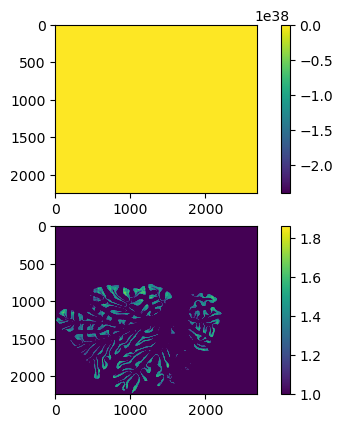

In [185]:
def generate_gc_layer_mask(img, conv_kernel_size = 10, lower_bin_thresh=1, bg_dilation_size = 5, bg_erosion_size = None):
    """
    Generates an approximate mask of the granular cell layer (not continuous)
    """
    if bg_erosion_size is None:
        bg_erosion_size = 2*bg_dilation_size
    #define our convolution kernel, which is set to 1 everywhere since we want to add all values 
    kernel = sitk.Image(conv_kernel_size,conv_kernel_size, sitk.sitkFloat32)
    kernel[:,:] = 1
    
    #convolve, then threshold @ set value (or change to otsu, thouhg noiser)
    convolved = sitk.Convolution(img,kernel,normalize=True)
    bin_mask = sitk.BinaryThreshold(convolved,lowerThreshold=lower_bin_thresh)
    
    component_image = sitk.ConnectedComponent(bin_mask) #find all connected components
    sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True) #sort by size
    img_bg = sorted_component_image == 0 #choose the background, easier to work with and then invert
    img_bg = sitk.InvertIntensity(sitk.ErodeObjectMorphology(sitk.DilateObjectMorphology(img_bg,[bg_dilation_size,bg_dilation_size]),[bg_erosion_size,bg_erosion_size]))
    return img_bg

        
# kernel = sitk.GetImageFromArray(np.ones((10,10),dtype=np.float32))
kernel_size = 10
kernel = sitk.Image(kernel_size,kernel_size, sitk.sitkFloat32)
kernel[:,:] = 1

convolved = sitk.Convolution(read_tiff_image(init_fixed),kernel,normalize=True)
# sitk.GaussianImageSource(
plt.subplot(2,1,1)
plt.imshow(sitk.GetArrayViewFromImage(read_tiff_image(init_fixed)),vmax=5),plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(sitk.GetArrayViewFromImage(convolved),vmin=1),plt.colorbar()
# plt.subplot(3,1,3)
# im_arr = sitk.GetArrayViewFromImage(convolved)
# im_vec = im_arr[im_arr>0]
# _ = plt.hist(im_vec,bins=100)


shrink factors: [6, 4, 2, 1]
smooth factors: [3, 2, 1, 0]


4397503.0

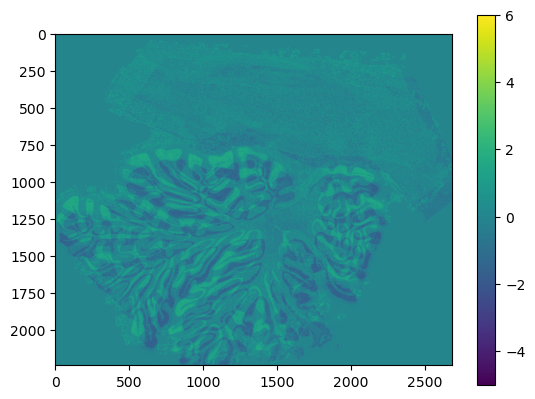

In [276]:
mm1 = generate_gc_layer_mask(fixed_image,conv_kernel_size=20)
mm2 = generate_gc_layer_mask(moving_image,conv_kernel_size=20)
res = sitk_reg_2d(fixed_image,moving_image,scaling_factor=32)
warped_orig = sitk.Resample(moving_image, fixed_image, res['xfm'],
                                  sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
plt.imshow(sitk.GetArrayViewFromImage(fixed_image)-sitk.GetArrayViewFromImage(warped_orig)),plt.colorbar()

np.sum((sitk.GetArrayViewFromImage(fixed_image) - sitk.GetArrayViewFromImage(warped_orig))**2)
# plt.imshow(sitk.GetArrayViewFromImage(mm2))
# plt.figure()
# plt.imshow(sitk.GetArrayViewFromImage(sitk.BinaryFillhole(mm2)))

3828678.0

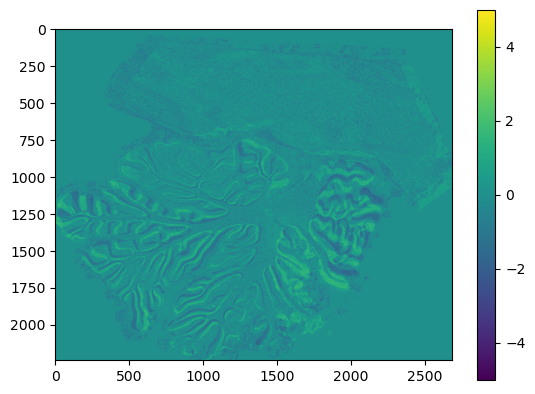

In [261]:
plt.imshow(-1*(sitk.GetArrayViewFromImage(fixed_image) - sitk.GetArrayViewFromImage(warped_orig))),plt.colorbar()

np.sum((sitk.GetArrayViewFromImage(fixed_image) - sitk.GetArrayViewFromImage(warped_orig))**2)

3827153.0

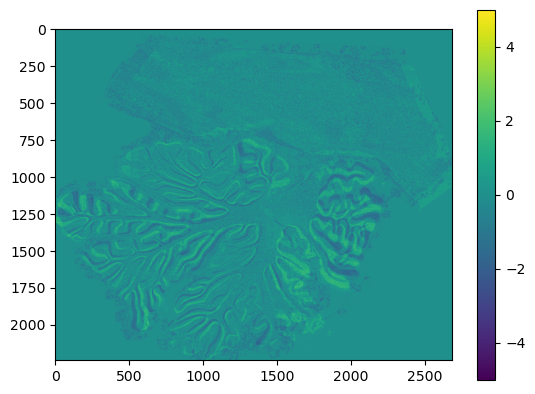

In [176]:
plt.imshow(-1*(sitk.GetArrayViewFromImage(fixed_image) - sitk.GetArrayViewFromImage(warped_orig))),plt.colorbar()

np.sum((sitk.GetArrayViewFromImage(fixed_image) - sitk.GetArrayViewFromImage(warped_orig))**2)

In [ ]:
plt.imshow(sitk.GetArrayViewFromImage(fixed_image)-sitk.GetArrayViewFromImage(res['warped_moving']),vmin=0,vmax=2),plt.colorbar()


<function SimpleITK.SimpleITK.InvertIntensity(image1, maximum=255)>

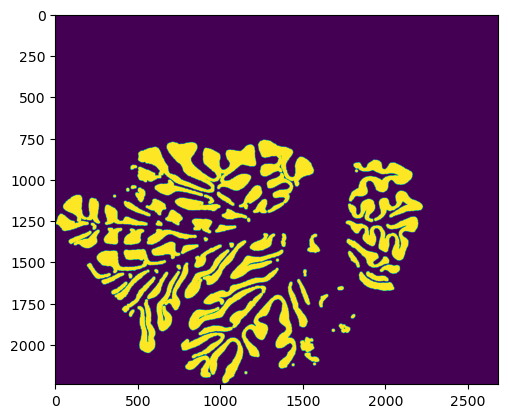

In [119]:
bin_cont = sitk.BinaryThreshold(convolved,lowerThreshold=1)
component_image = sitk.ConnectedComponent(bin_cont)
# dims = bin_cont.getDimension()
ero_kernel = sitk.Image(3,3,sitk.sitkInt8)
ero_kernel[:,:] = 1
# plt.imshow(sitk.GetArrayViewFromImage((bin_cont)))
# plt.figure()
# plt.imshow(sitk.GetArrayViewFromImage(sitk.ConnectedComponent(bin_cont)))
sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True)
largest_component_binary_image = sorted_component_image == 0
largest_component_binary_image = sitk.InvertIntensity(sitk.ErodeObjectMorphology(sitk.DilateObjectMorphology(largest_component_binary_image,[4,4]),[8,8]))
plt.figure()
plt.imshow(sitk.GetArrayViewFromImage(largest_component_binary_image))
sitk.InvertIntensity

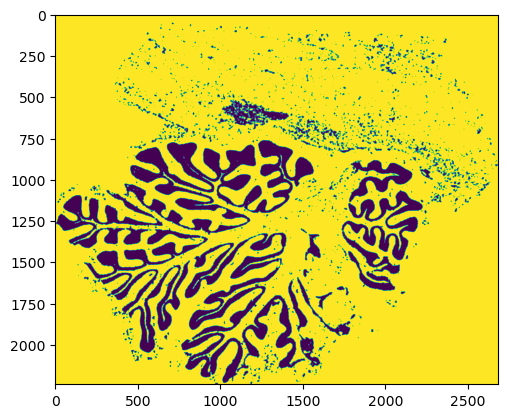

In [114]:
bin_cont = sitk.OtsuThreshold(convolved)
plt.imshow(sitk.GetArrayViewFromImage(img))

In [97]:
plt.imshow(sitk.GetArrayViewFromImage(largest_component_binary_image))

RuntimeError: Exception thrown in SimpleITK Show: /usr/share/miniconda/envs/bld/conda-bld/simpleitk_1670967018106/work/Code/IO/src/sitkImageViewer.cxx:620:
sitk::ERROR: No ImageJ/Fiji application found.

In [91]:
sitk.GetArrayViewFromImage(largest_component_binary_image).sum()

83290

In [88]:
sorted_component_image[0].GetSizeOfObjectsInPixels()

IndexError: invalid slice extraction to 1 dimension

In [85]:
sorted_component_image.Get

(2685, 2240)

In [64]:
sitk.ConnectedComponent(bin_cont)

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f260e656870> >

In [3]:
#for now we just assume that the file numbers refer to the correct slices (THEY DO NOT, YOU WILL NEED TO DO A LOOKUP based on the spreadsheet b/c the ordering is wrong in some!)
max_img_num = np.array([im_str.split('.vsi')[0].split('_Image_')[1] for im_str in im_list]).astype(int).max() #max of standard images
im_list_len = len(im_list)

if im_list_len > max_img_num:
    max_img_num = im_list_len
print(f"total number of images to register: {max_img_num}")

#determine where the largest slice is, this will be the reference for all initial registration
max_sz = (0,0)
max_sz_idx = 0
for idx,im in enumerate(im_list):
    sz = io.imread(im).shape
    if sz > max_sz:
        max_sz = sz
        max_sz_idx = idx
        
reverse_reg_im_list = im_list[0:max_sz_idx][::-1] #reverse the order of the images that comes prior to the initial target slice so that the reg will go in the correct order (you will need to reverse it before creating the output file)
forward_reg_im_list = im_list[max_sz_idx+1:] #we skip the one that will be the initial target
init_fixed = im_list[max_sz_idx]


total number of images to register: 110


(array([2053113.,  395407.,  929322., 1154537.,  602237.,  384858.,
         268383.,  152651.,   58137.,   15755.]),
 array([0.        , 0.15030053, 0.30060107, 0.45090157, 0.60120213,
        0.75150263, 0.90180314, 1.05210364, 1.20240426, 1.35270476,
        1.50300527]),
 <BarContainer object of 10 artists>)

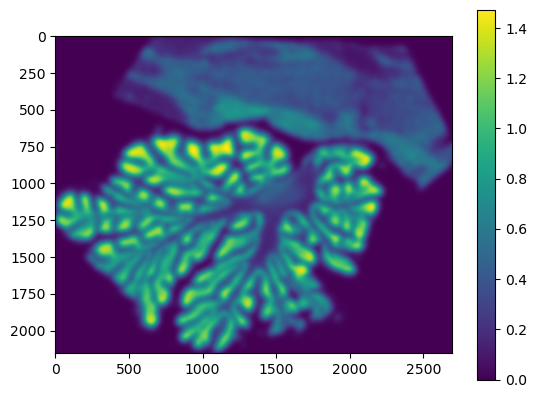

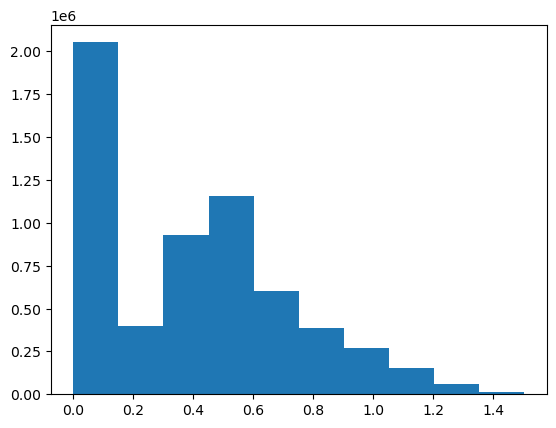

In [15]:
filt_d_moving = (gaussian(sitk.GetArrayViewFromImage(moving_image),20))

filt_d_fixed = (gaussian(sitk.GetArrayViewFromImage(fixed_image),20))
plt.imshow(filt_d_moving),plt.colorbar()
plt.figure()
plt.hist((filt_d_fixed).ravel())

In [8]:

fixed_image = read_tiff_image(init_fixed)
moving_image = read_tiff_image(reverse_reg_im_list[0])
res = sitk_reg_2d(fixed_image,moving_image)
warped_moving = res['warped_moving']

filt_d_moving = (gaussian(sitk.GetArrayViewFromImage(moving_image),30))
filt_d_moving[filt_d_moving<0.03] = 0 
filt_d_moving[filt_d_moving>0] = 1 
# filt_d_moving =  ndimage.distance_transform_edt(np.logical_not(filt_d_moving))
filt_d_moving[filt_d_moving>50]=0
filt_moving = sitk.GetImageFromArray(filt_d_moving)

filt_d_fixed = (gaussian(sitk.GetArrayViewFromImage(fixed_image),30))
filt_d_fixed[filt_d_fixed<0.03] = 0 
filt_d_fixed[filt_d_fixed>0] = 1
# filt_d_fixed =  ndimage.distance_transform_edt(np.logical_not(filt_d_fixed))
filt_d_fixed[filt_d_fixed>50]=0
filt_fixed = sitk.GetImageFromArray(filt_d_fixed)
res = sitk_reg_2d(filt_fixed,filt_moving)
filt_warped_moving = res['warped_moving']

3832106.0
316979113.8941523


(<matplotlib.image.AxesImage at 0x7f2607842430>,
 <matplotlib.colorbar.Colorbar at 0x7f26078d01c0>)

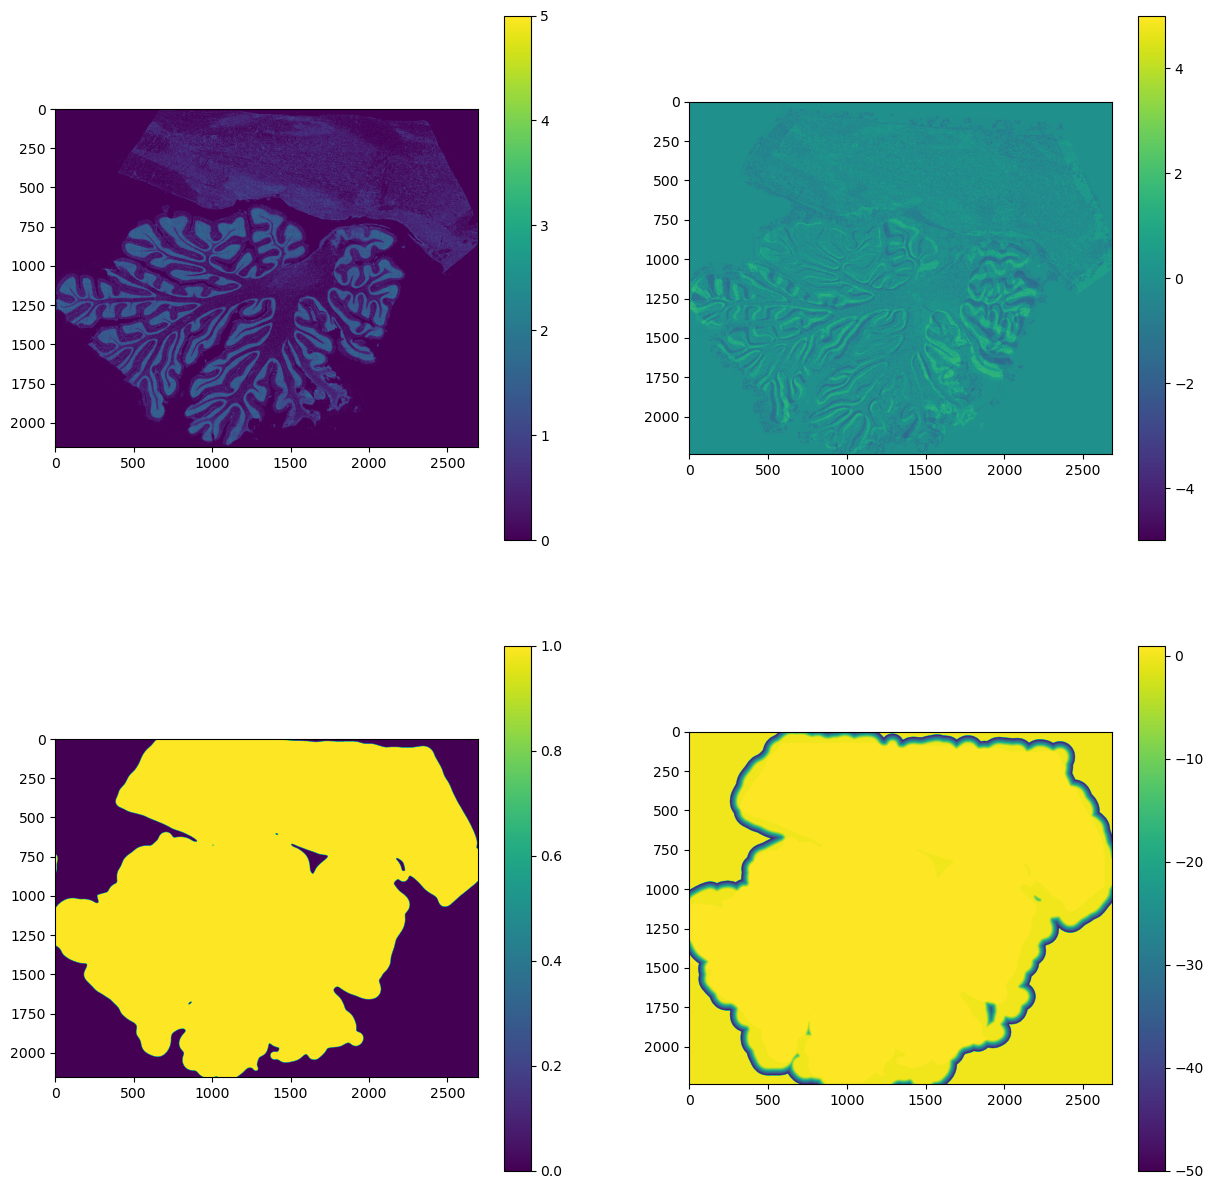

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayViewFromImage(moving_image)), plt.colorbar()
plt.subplot(2,2,2)
sitk_diff = sitk.GetArrayViewFromImage(warped_moving) - sitk.GetArrayFromImage(fixed_image)
print(np.sum(sitk_diff**2))
plt.imshow(sitk_diff,vmin=-5,vmax=5), plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(filt_d_moving), plt.colorbar()
plt.subplot(2,2,4)
sitk_diff = sitk.GetArrayViewFromImage(filt_warped_moving) - sitk.GetArrayFromImage(filt_fixed)
print(np.sum(sitk_diff**2))
plt.imshow(sitk_diff), plt.colorbar()

In [4]:
if max_sz_idx != 0: #if we have some images prior to the largest image
    #do reverse reg first
    revese_reg_ims = compute_slicewise_reg(reverse_reg_im_list, init_fixed)

0: ./_Image_06.vsi - 20x.tif <- ./_Image_05.vsi - 20x.tif
1: ./_Image_05.vsi - 20x.tif <- ./_Image_02.vsi - 20x.tif
2: ./_Image_02.vsi - 20x.tif <- ./_Image_01.vsi - 20x.tif


In [162]:
#now forward regs
forward_reg_ims = compute_slicewise_reg(forward_reg_im_list, init_fixed)

0: ./_Image_06.vsi - 20x.tif <- ./_Image_07.vsi - 20x.tif
(2685, 2240)
1: ./_Image_07.vsi - 20x.tif <- ./_Image_09.vsi - 20x.tif
(2685, 2240)
2: ./_Image_09.vsi - 20x.tif <- ./_Image_10.vsi - 20x.tif
(2685, 2240)
3: ./_Image_10.vsi - 20x.tif <- ./_Image_11.vsi - 20x.tif
(2685, 2240)
4: ./_Image_11.vsi - 20x.tif <- ./_Image_12.vsi - 20x.tif
(2685, 2240)
5: ./_Image_12.vsi - 20x.tif <- ./_Image_14.vsi - 20x.tif
(2685, 2240)
6: ./_Image_14.vsi - 20x.tif <- ./_Image_15.vsi - 20x.tif
(2685, 2240)
7: ./_Image_15.vsi - 20x.tif <- ./_Image_16.vsi - 20x.tif
(2685, 2240)
8: ./_Image_16.vsi - 20x.tif <- ./_Image_17.vsi - 20x.tif
(2685, 2240)
9: ./_Image_17.vsi - 20x.tif <- ./_Image_19.vsi - 20x.tif
(2685, 2240)
10: ./_Image_19.vsi - 20x.tif <- ./_Image_20.vsi - 20x.tif
(2685, 2240)
11: ./_Image_20.vsi - 20x.tif <- ./_Image_21.vsi - 20x.tif
(2685, 2240)
12: ./_Image_21.vsi - 20x.tif <- ./_Image_22.vsi - 20x.tif
(2685, 2240)
13: ./_Image_22.vsi - 20x.tif <- ./_Image_23.vsi - 20x.tif
(2685, 2240)
14

In [168]:
#now reconstruct as 3d

warped_ims_list= revese_reg_ims['warped_im_list'] + [read_tiff_image(init_fixed)] + forward_reg_ims['warped_im_list']
im_idxs = [im_str.split('.vsi')[0].split('_Image_')[1] for im_str in reverse_reg_im_list + [init_fixed] + forward_reg_im_list]
im_idxs = np.array(im_idxs).astype(int)
im_idxs[-1] = im_idx[-2]+1

print('converting')
img_out2 = convert_slices_to_image(warped_ims_list,im_idxs)
write_image(img_out2,'./xxx_sitk_all_new.nii.gz')

[ 5  2  1  6  7  9 10 11 12 14 15 16 17 19 20 21 22 23 24 25 27 28 30 31]
converting
(2685, 2240, 100)
110
110
Adding slice at position index: 
5,2,1,6,7,9,10,11,12,14,15,16,17,19,20,21,22,23,24,25,27,28,30,31,32,33,35,36,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,61,62,62,63,64,64,65,65,66,66,67,68,68,69,69,70,70,71,72,72,73,73,74,75,75,76,76,77,78,79,80,80,81,81,82,83,83,84,85,85,86,86,87,89,90,90,91,91,92,93,93,94,94,95,95,98,99,99,31,
Image written to: ./xxx_sitk_all_new.nii.gz


In [179]:
#sitk.JoinSeries([sitk.ReadImage(file, imageIO="TIFFImageIO") for file in im_list])

In [181]:
xfm

{'xfm': <SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7f77587d4e10> >,
 'warped_moving': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f77587d4360> >}

In [5]:

fixed_image = read_tiff_image(init_fixed)
moving_image = read_tiff_image(reverse_reg_im_list[0])
res = sitk_reg_2d(fixed_image,moving_image)
warped_moving = res['warped_moving']

filt_d_moving = sobel(gaussian(sitk.GetArrayViewFromImage(moving_image),20))
filt_d_moving[filt_d_moving<0.03] = 0 
filt_d_moving[filt_d_moving>0] = 1 
filt_d_moving =  ndimage.distance_transform_edt(np.logical_not(filt_d_moving))
filt_d_moving[filt_d_moving>50]=0
filt_moving = sitk.GetImageFromArray(filt_d_moving)

filt_d_fixed = sobel(gaussian(sitk.GetArrayViewFromImage(fixed_image),20))
filt_d_fixed[filt_d_fixed<0.03] = 0 
filt_d_fixed[filt_d_fixed>0] = 1
filt_d_fixed =  ndimage.distance_transform_edt(np.logical_not(filt_d_fixed))
filt_d_fixed[filt_d_fixed>50]=0
filt_fixed = sitk.GetImageFromArray(filt_d_fixed)
res = sitk_reg_2d(filt_fixed,filt_moving)
filt_warped_moving = res['warped_moving']

NameError: name 'sobel' is not defined

3844303.0
1105214597.7503407


(<matplotlib.image.AxesImage at 0x7f76eecfb730>,
 <matplotlib.colorbar.Colorbar at 0x7f76f1ce7eb0>)

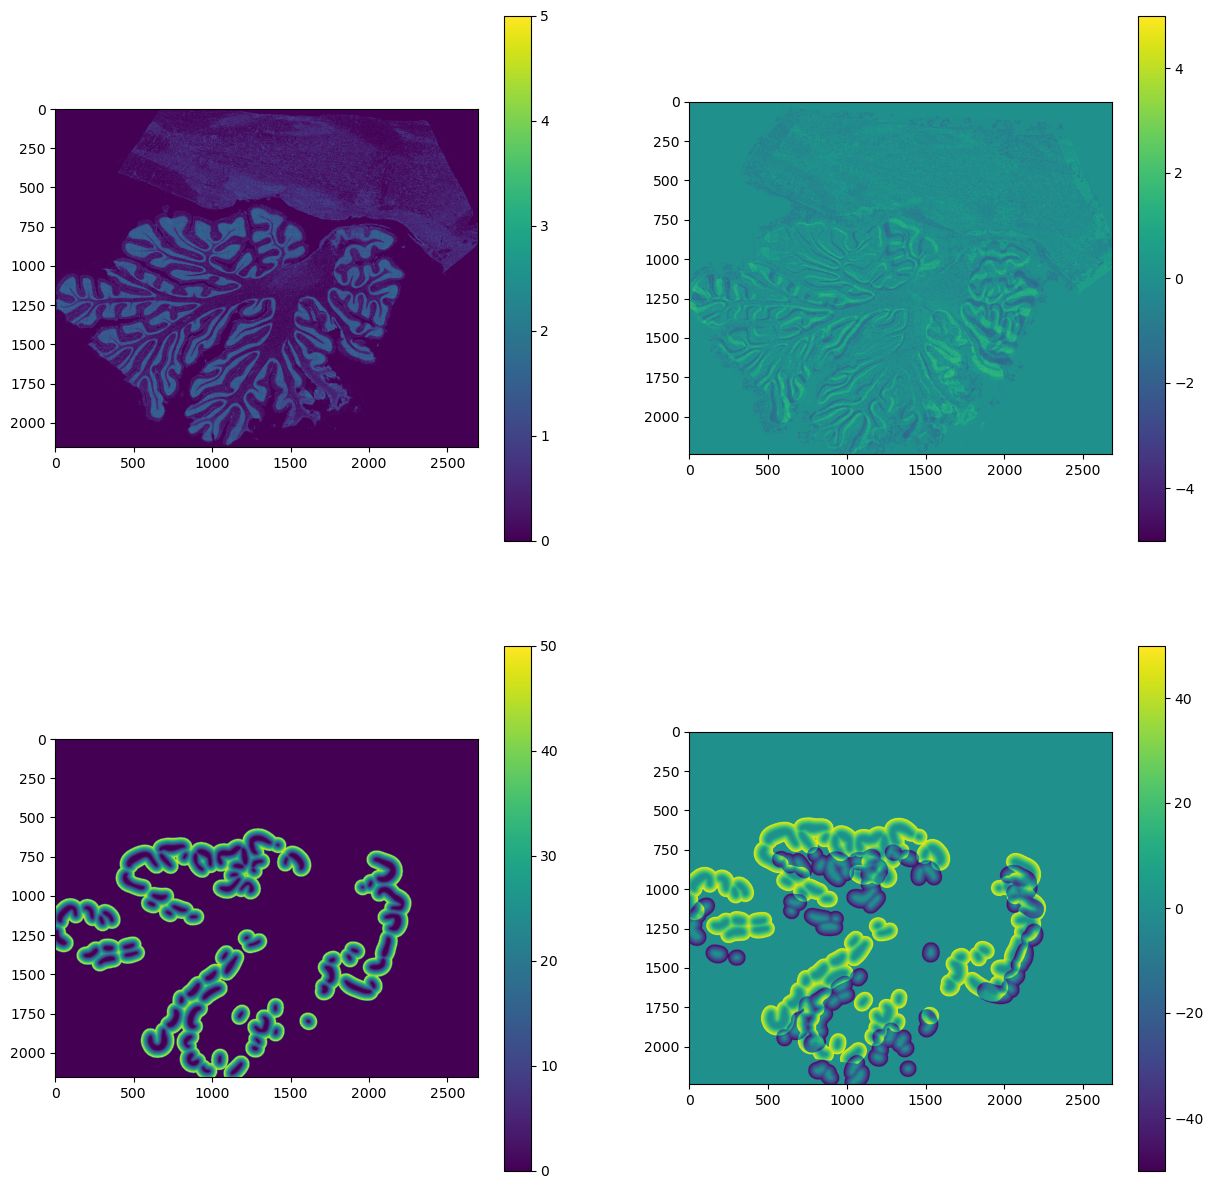

In [280]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayViewFromImage(moving_image)), plt.colorbar()
plt.subplot(2,2,2)
sitk_diff = sitk.GetArrayViewFromImage(warped_moving) - sitk.GetArrayFromImage(fixed_image)
print(np.sum(sitk_diff**2))
plt.imshow(sitk_diff,vmin=-5,vmax=5), plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(filt_d_moving), plt.colorbar()
plt.subplot(2,2,4)
sitk_diff = sitk.GetArrayViewFromImage(filt_warped_moving) - sitk.GetArrayFromImage(filt_fixed)
print(np.sum(sitk_diff**2))
plt.imshow(sitk_diff), plt.colorbar()

In [210]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.filters import sobel
s = np.linspace(0, 2*np.pi, 400)
r = 1000 + 1000*np.sin(s)
c = 2200 + 1000*np.cos(s)
init = np.array([r, c]).T

# snake = active_contour(gaussian(sitk.GetArrayViewFromImage(moving_image), 3, preserve_range=False),
#                        init, alpha=0.015, beta=10, gamma=0.001)

(<matplotlib.image.AxesImage at 0x7f76f0b95340>,
 <matplotlib.colorbar.Colorbar at 0x7f76f0b47d60>)

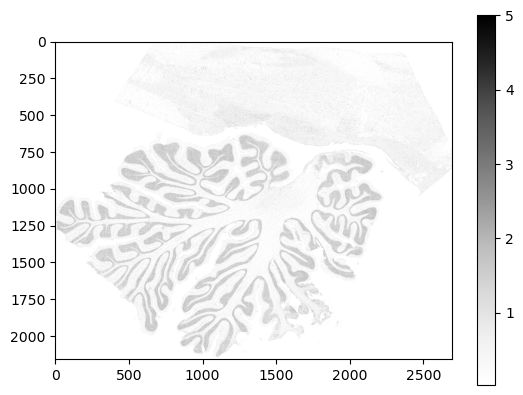

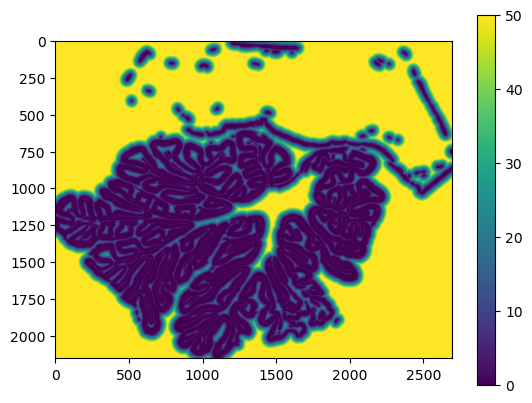

In [270]:
the_img = sitk.GetArrayFromImage(moving_image)

plt.imshow(the_img,cmap='Greys',vmin=0.03),plt.colorbar()
plt.figure()
the_img = sobel(gaussian(the_img,20))
the_img[the_img>.02]=3
the_img[the_img<=0.02]=1
the_img[the_img==3]=0

img_dst = ndimage.distance_transform_edt(the_img)
plt.imshow(img_dst,vmax=50),plt.colorbar()

(array([1.550765e+06, 8.742800e+04, 6.646700e+04, 5.278600e+04,
        4.356300e+04, 3.610700e+04, 3.153700e+04, 2.846000e+04,
        2.718100e+04, 2.583300e+04, 2.434100e+04, 2.313500e+04,
        2.297300e+04, 2.206800e+04, 2.167100e+04, 2.205700e+04,
        2.184500e+04, 2.217100e+04, 2.212300e+04, 2.223800e+04,
        2.219200e+04, 2.231200e+04, 2.255500e+04, 2.212900e+04,
        2.269600e+04, 2.273000e+04, 2.236500e+04, 2.268300e+04,
        2.276200e+04, 2.296500e+04, 2.286400e+04, 2.263400e+04,
        2.276000e+04, 2.253400e+04, 2.267400e+04, 2.231700e+04,
        2.241700e+04, 2.256400e+04, 2.227600e+04, 2.189400e+04,
        2.200200e+04, 2.147100e+04, 2.135300e+04, 2.117000e+04,
        2.113400e+04, 2.072100e+04, 2.037000e+04, 2.041700e+04,
        2.017600e+04, 1.989500e+04, 1.951000e+04, 1.971600e+04,
        1.921000e+04, 1.925600e+04, 1.885300e+04, 1.862500e+04,
        1.847800e+04, 1.803300e+04, 1.768000e+04, 1.762800e+04,
        1.729500e+04, 1.703900e+04, 1.71

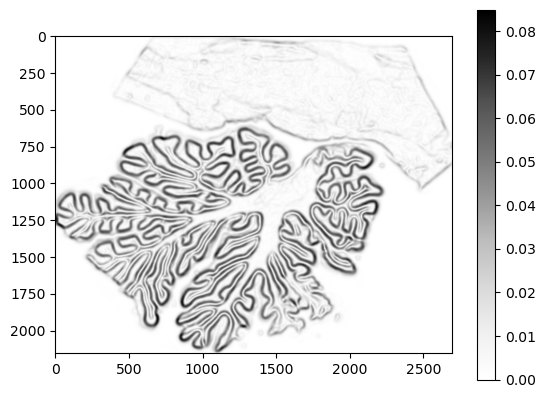

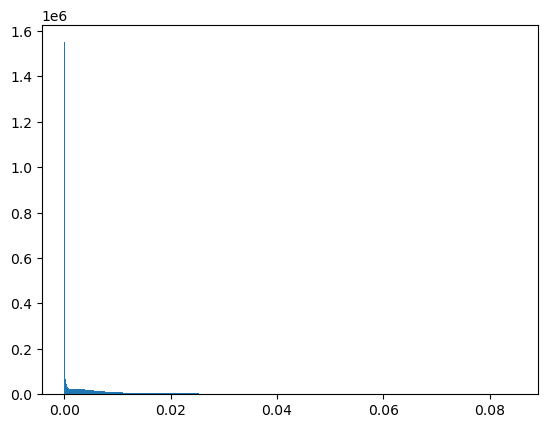

In [234]:
the_img = sobel(gaussian(sitk.GetArrayViewFromImage(moving_image),10))
plt.imshow(the_img,cmap='Greys'),plt.colorbar()
# plt.ylim(1000,1500)
# plt.xlim(0,500)
# plt.figure()
# h=plt.hist(the_img.ravel(),bins=1000)

(0.0, 2695.0, 2155.0, 0.0)

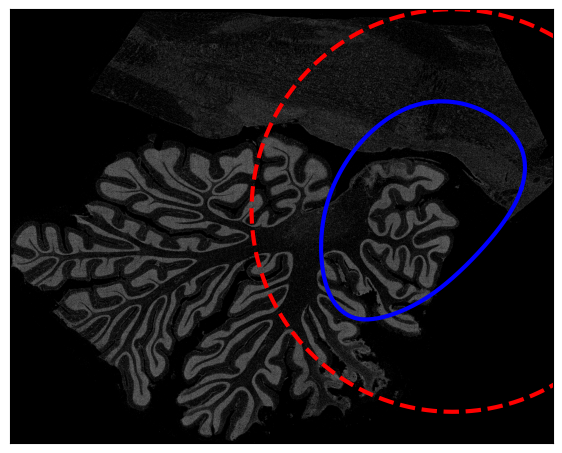

In [201]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(sitk.GetArrayViewFromImage(moving_image), cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, sitk.GetArrayViewFromImage(moving_image).shape[1], sitk.GetArrayViewFromImage(moving_image).shape[0], 0])

In [142]:
xfm_im_list = []
xfm_list = []
for idx in np.arange(len(im_list)-1):
    print(f"{idx}",end=': ')
    fname_moving = im_list[idx+1]
    im1=io.imread(fname_moving)
    moving = ants.from_numpy(im1)
    fname_fixed = im_list[idx]
    
    if idx == 0: #first time, so moving goes to fixed as is
        im0=io.imread(fname_fixed)
        fixed = ants.from_numpy(im0) #convert from standard type to antsImage type
        xfm_im_list.append(fixed)
    else: #we just update what fixed is
        fixed = mywarpedimage

    print(f"{fname_fixed} <- {fname_moving}")
    mytx = ants.registration(fixed,moving,type_of_transform='Rigid',reg_iterations=(100,100,100),aff_random_sampling_rate=.5, verbose=False)
    mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,
                                           transformlist=mytx['fwdtransforms'],interpolation='nearest')
    xfm_list.append(mytx)
    xfm_im_list.append(mywarpedimage) #append what our target is
    



0: ./_Image_09.vsi - 20x.tif <- ./_Image_10.vsi - 20x.tif
1: ./_Image_10.vsi - 20x.tif <- ./_Image_11.vsi - 20x.tif
2: ./_Image_11.vsi - 20x.tif <- ./_Image_12.vsi - 20x.tif


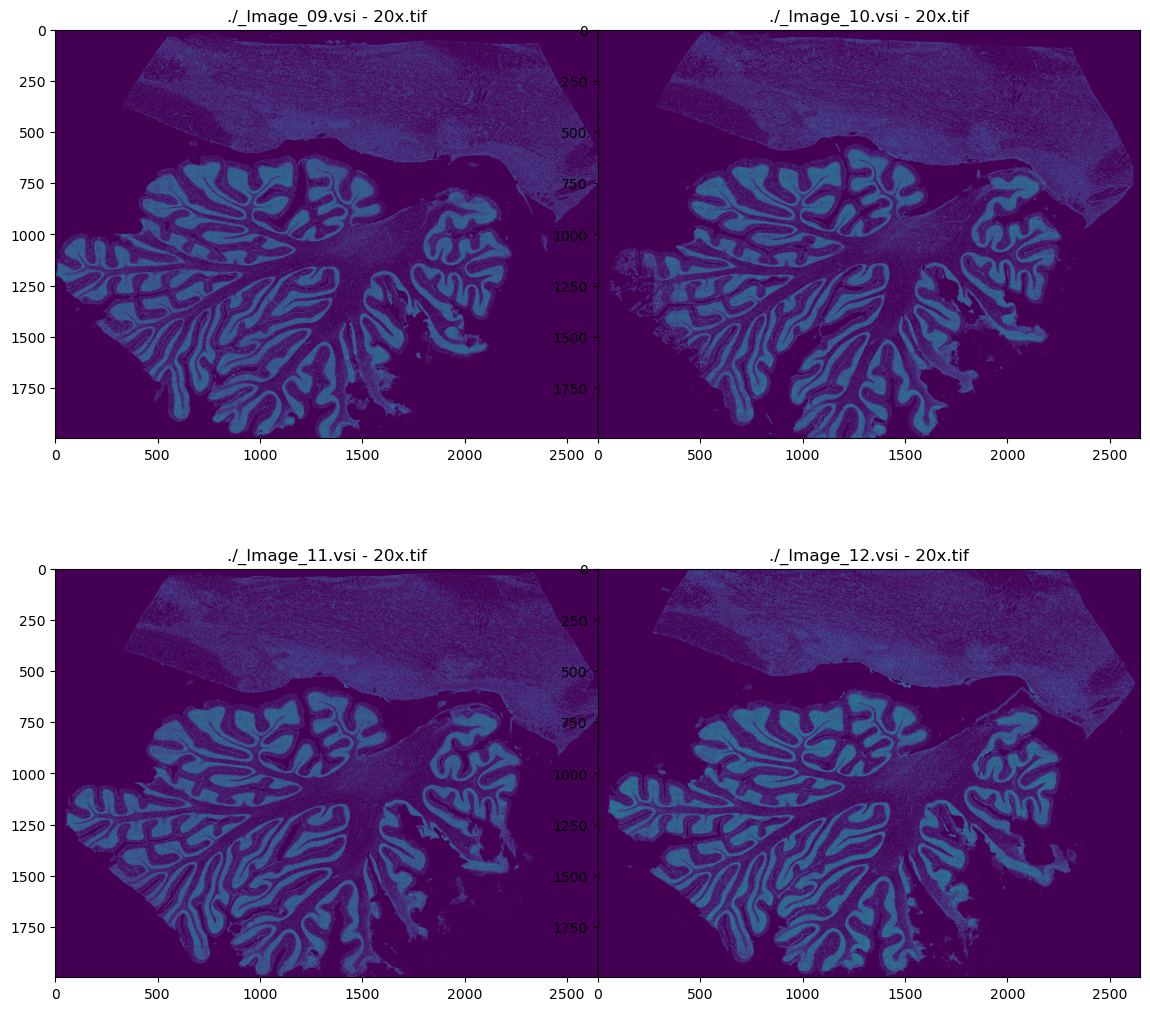

In [146]:
num_rows = np.ceil(len(xfm_im_list)/2.).astype(int)
plt.figure(figsize=(7*num_rows,7*num_rows))

for idx,im in enumerate(xfm_im_list):
    plt.subplot(num_rows,num_rows,idx+1)
    plt.imshow(im.numpy())
    plt.title(im_list[idx])
plt.subplots_adjust(wspace=0, hspace=0)

In [147]:
d_out = np.zeros((xfm_im_list[0].shape+(len(xfm_im_list),)))
for idx,im in enumerate(xfm_im_list):
    d_out[...,idx] = im.numpy()


In [151]:
im_out = ants.from_numpy(d_out)
im_out.set_spacing((10,10,50))
ants.image_write(im_out,'./test_Rigid.nii.gz')


In [152]:
ants.image_write(ants.smooth_image(im_out,(10,10,2)),'./test_Rigid_s2.nii.gz')

Signature: im_out.set_spacing(new_spacing)
Docstring:
Set image spacing

Arguments
---------
new_spacing : tuple or list
    updated spacing for the image.
    should have one value for each dimension

Returns
-------
None
File:      /opt/quarantine/miniforge/envs/py3p9/lib/python3.9/site-packages/ants/core/ants_image.py
Type:      method

In [83]:
print(mytx)

{'warpedmovout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2191, 2713)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'warpedfixout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2141, 2594)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmpa619l8u70GenericAffine.mat'], 'invtransforms': ['/tmp/tmpa619l8u70GenericAffine.mat']}


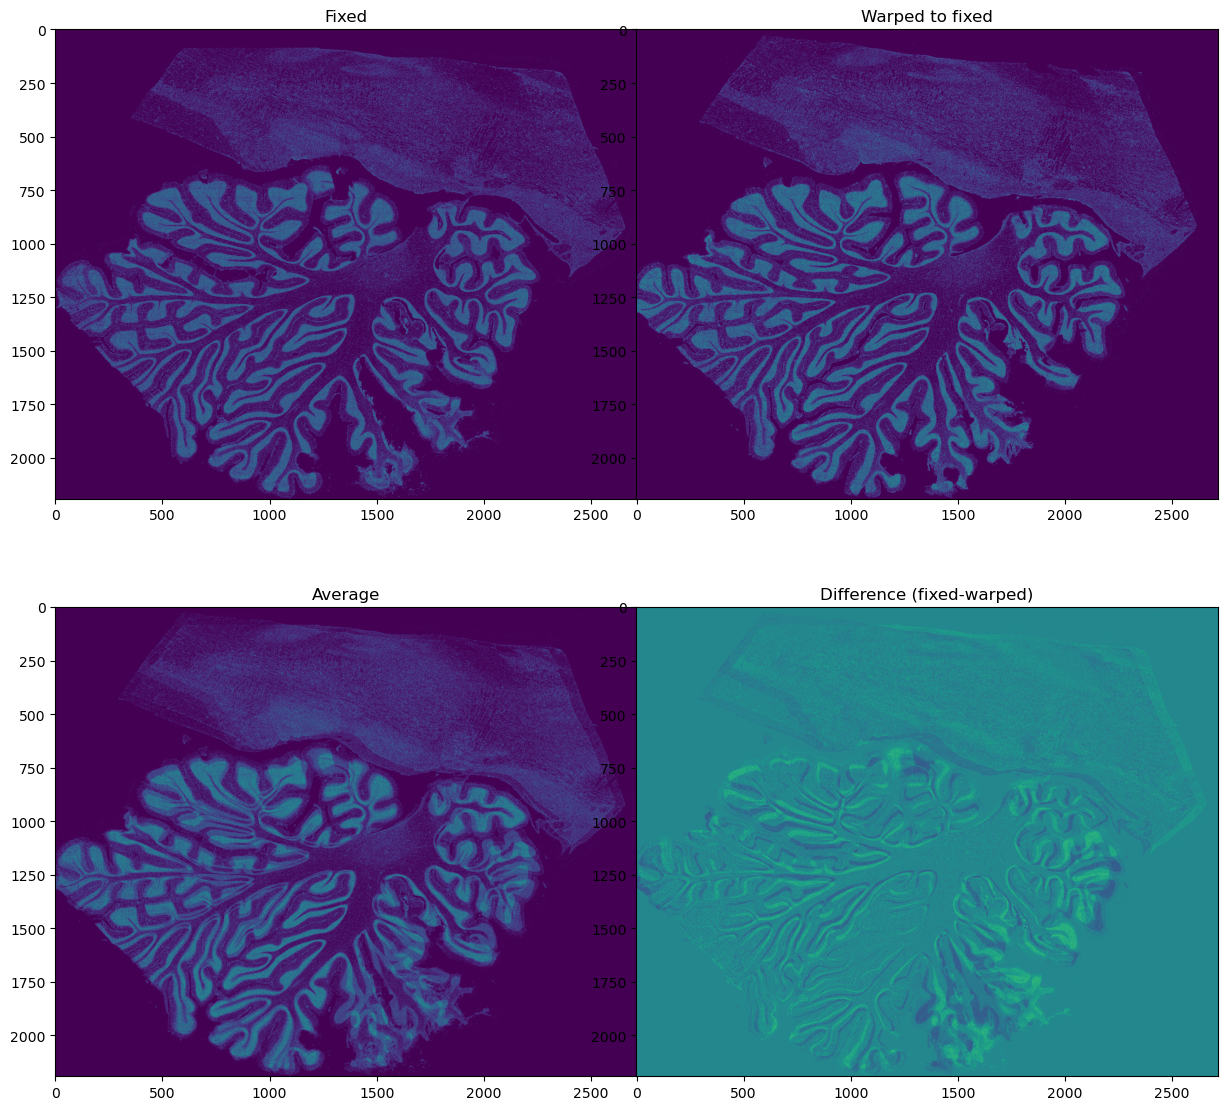

In [85]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.title('Fixed')
plt.imshow(fixed.numpy())
plt.subplot(2,2,2)
plt.title('Warped to fixed')
plt.imshow(mywarpedimage.numpy())
plt.subplot(2,2,3)
plt.title('Average')
plt.imshow(.5*(fixed.numpy()+mywarpedimage.numpy()))

plt.subplot(2,2,4)
plt.title('Difference (fixed-warped)')
plt.imshow((fixed.numpy()-mywarpedimage.numpy()))

plt.subplots_adjust(wspace=0, hspace=0)
# plt.

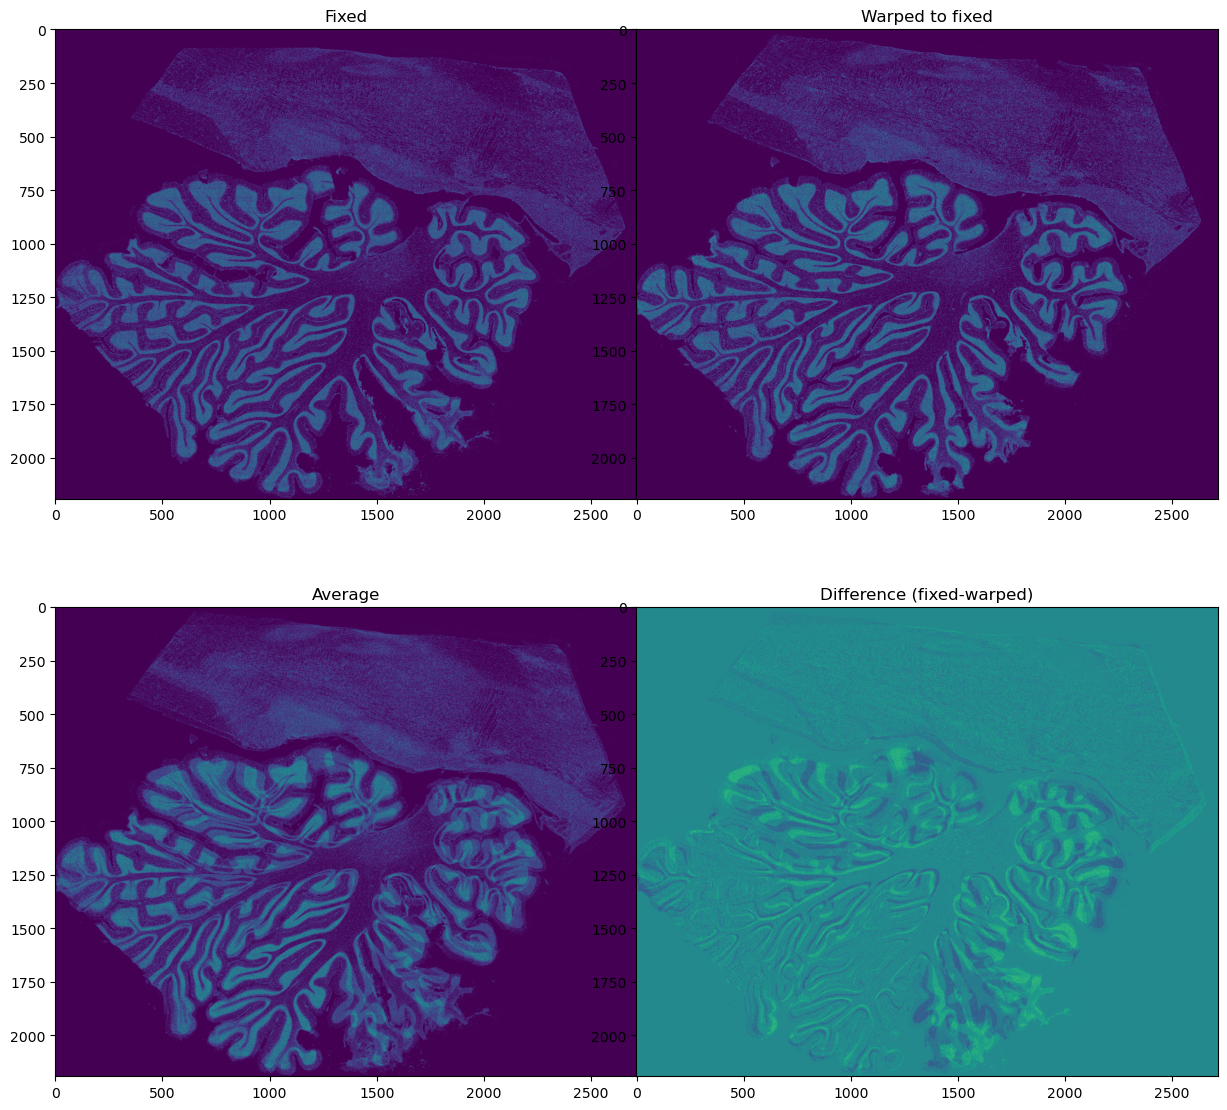

In [80]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.title('Fixed')
plt.imshow(fixed.numpy())
plt.subplot(2,2,2)
plt.title('Warped to fixed')
plt.imshow(mywarpedimage.numpy())
plt.subplot(2,2,3)
plt.title('Average')
plt.imshow(.5*(fixed.numpy()+mywarpedimage.numpy()))

plt.subplot(2,2,4)
plt.title('Difference (fixed-warped)')
plt.imshow((fixed.numpy()-mywarpedimage.numpy()))

plt.subplots_adjust(wspace=0, hspace=0)
# plt.